# Word embeddings

In [1]:
!pip install -U gensim
!pip install -U "datasets<3.0"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.6.1 which is incompatible.


In [2]:
import datasets # Biblioteca de manejo de conjuntos de datos para procesamiento de lenguaje natural
import re
import gensim # Biblioteca de modelamiento de lenguaje
import numpy as np # Biblioteca de manejo de datos vectoriales
import sklearn.linear_model # Módulo de sklearn de modelamiento lineal
import sklearn.decomposition # Módulo de sklearn donde está PCA
import plotly.express as px # Biblioteca de visualización
import urllib # Módulo de python para el manejo de consultas web

Cargamos el conjunto de datos del curso.

In [3]:
spanish_diagnostics = datasets.load_dataset('fvillena/spanish_diagnostics') # Cargamos las particiones de entrenamiento y prueba

Generating train split:   0%|          | 0/70000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Preprocesamos el corpus.

In [4]:
#Reutilizamos la función de normalización vista en labs anteriores
def normalize(text, remove_tildes = True):
    """Normaliza una cadena de texto convirtiéndo todo a minúsculas, quitando los caracteres no alfabéticos y los tildes"""
    text = text.lower() # Llevamos todo a minúscula
    text = re.sub(r'[^A-Za-zñáéíóú]', ' ', text) # Reemplazamos los caracteres no alfabéticos por un espacio
    if remove_tildes:
        text = re.sub('á', 'a', text) # Reemplazamos los tildes
        text = re.sub('é', 'e', text)
        text = re.sub('í', 'i', text)
        text = re.sub('ó', 'o', text)
        text = re.sub('ú', 'u', text)
    return text

In [5]:
spanish_diagnostics_normalized = spanish_diagnostics.map(
    lambda x: {
        "normalized_text" : normalize(x["text"])
    })

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

In [6]:
spanish_diagnostics_normalized_tokenized = spanish_diagnostics_normalized.map(
    lambda x: {
        "tokenized_text" : x["normalized_text"].split()
    })

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

## Word embeddings

Los word embeddings son representaciones vectoriales de palabras. A cada una de las palabras de nuestro vocabulario se les asigna un vector que la representa y estas representaciones guardan relaciones semánticas del lenguaje natural. Por ejemplo, palabras semánticamente similares tienen a estar más cerca en el espacio que palabras no tan similares entre sí.

Para calcular estas representaciones utilizaremos el método Word2Vec, en su implementación de la biblioteca Gensim.

Primero, como es usual, creamos el modelo. En este caso, usaremos uno de los primero modelos de embeddings neuronales: `word2vec`

Algunos parámetros importantes:

- `min_count`: Ignora todas las palabras que tengan frecuencia menor a la indicada.
- `window` : Tamaño de la ventana. Usaremos 4.
- `size` : El tamaño de los embeddings que crearemos. Por lo general, el rendimiento sube cuando se usan mas dimensiones, pero después de 300 ya no se nota cambio. Ahora, usaremos solo 100.
- `(Recomendable) workers`: Cantidad de CPU que serán utilizadas en el entrenamiento.

In [42]:
model = gensim.models.Word2Vec(sentences= spanish_diagnostics_normalized_tokenized["train"]["tokenized_text"], min_count=10,
                window=4,
                vector_size=100,
                sample=6e-5,
                alpha=0.03,
                min_alpha=0.0007,
                negative=20)

Tenemos una representación de 100 dimensiones para cada una de las palabras del vocabulario.

In [44]:
model.wv.vectors.shape

(3963, 100)

Si extraemos el vector asociado a una palabra se observa que está constituido de números reales.

In [45]:
model.wv["pieza"]

array([-7.66507804e-01,  4.73688334e-01,  2.77297616e-01,  1.41292468e-01,
       -8.34468603e-02, -6.83131218e-01,  6.37405217e-02,  5.96791923e-01,
       -2.54690140e-01, -4.79177624e-01, -1.77309409e-01, -2.95547336e-01,
       -9.93575752e-02,  1.35741934e-01,  4.70039159e-01, -2.95943648e-01,
        8.67298990e-02, -9.21646178e-01, -4.62397337e-02, -2.24963635e-01,
       -1.21626742e-02,  1.58132657e-01,  2.04670206e-01,  1.14830464e-01,
        2.17816934e-01,  9.01518241e-02, -3.23183499e-02, -3.90252411e-01,
        1.03371672e-01, -7.32524619e-02,  5.70718467e-01, -4.14428830e-01,
        5.31358838e-01, -4.87923235e-01, -1.04878533e+00,  4.13107187e-01,
        1.39763430e-01, -8.90512988e-02, -3.00135314e-02,  6.73300400e-02,
        4.32060659e-01, -4.55544889e-01, -1.87465817e-01,  6.97405815e-01,
       -3.47611994e-01,  1.08942710e-01,  1.59425825e-01, -3.13569009e-01,
        2.38120202e-02,  5.01304716e-02,  5.18329382e-01, -6.84503078e-01,
        8.52074102e-03,  

### Entrenar el modelo

Al definir el modelo de `Word2Vec` si se le entregan directamente los datos, se contruye inmediatamente el vocabulario y se entrena el modelo para obtener los `word embeddings` de los textos. Sin embargo estos 2 pasos también se pueden realizar de forma explícita para obtener un mayor control de los hiperparámetros.

### Construir el vocabulario

Para esto, se creará un conjunto que contendrá (una sola vez) todas aquellas palabras que aparecen mas de `min_count` veces.

In [46]:
model.build_vocab(spanish_diagnostics_normalized_tokenized["train"]["tokenized_text"], progress_per=10000)

### Entrenar el Modelo como tal

A continuación, entenaremos el modelo.
Los parámetros que usaremos serán:

- `total_examples`: Número de documentos.
- `epochs`: Número de veces que se iterará sobre el corpus.

Es recomendable que tengan instalado `cpython` antes de continuar. Aumenta bastante la velocidad de entrenamiento.

In [47]:
import time
from time import time

In [48]:
t = time()
model.train(spanish_diagnostics_normalized_tokenized["train"]["tokenized_text"], total_examples=model.corpus_count, epochs=4, report_delay=0) # report_delay=0 reports at the end of each epoch
print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

Time to train the model: 0.11 mins


Una de las métricas más utilizadas para establecer distancias entre vectores de palabras es la similaridad coseno, esta métrica está por defecto utilizada cuando deseamos saber las palabras más cercanas a un palabra que consultamos. Se observa que las palabras más cercanas a la palabra consultada guardan una estrecha relación semántica.

### Similaridad

In [49]:
model.wv.most_similar("pieza")

[('pza', 0.9713157415390015),
 ('corona', 0.95909184217453),
 ('raiz', 0.9522993564605713),
 ('restauracion', 0.9435532689094543),
 ('endodoncia', 0.9430904984474182),
 ('pd', 0.9403972625732422),
 ('camara', 0.9392217397689819),
 ('pz', 0.9369812607765198),
 ('obturacion', 0.9367210268974304),
 ('profundas', 0.9313358068466187)]

Para continuar con la verificación de la similaridad de palabras establecemos pares de palabras en donde cada vez iremos alejándolas semánticamente. También podemos concluir que nuestro modelo pudo satisfactoriamente representar estas distancias de manera correcta.

In [50]:
pairs = [
    ('pieza', 'diente'), # Palabras muy cercanas semánticamente
    ('pieza', 'caries'),
    ('pieza', 'protesis'),
    ('pieza', 'hueso'),
    ('pieza', 'sangre') # Palabras muy lejanas semanticamente
]

In [51]:
for w1, w2 in pairs:
    print('%r\t%r\t%.2f' % (w1, w2, model.wv.similarity(w1, w2)))

'pieza'	'diente'	0.89
'pieza'	'caries'	0.88
'pieza'	'protesis'	0.61
'pieza'	'hueso'	0.57
'pieza'	'sangre'	0.41


Una de las aplicaciones de la similaridad de palabras es la detección de palabras fuera de contexto en una lista de palabras. En este caso el modelo detectó correctamente la palabra extraña.

In [52]:
model.wv.doesnt_match(["diente","periodontitis","cirrosis","corona","lengua"])

'cirrosis'

### Analogía

> Analogía, significa comparación o relación entre varias cosas, razones o conceptos; comparar o relacionar dos o más seres u objetos a través de la razón; señalando características generales y particulares comunes que permiten justificar la existencia de una propiedad en uno, a partir de la existencia de dicha propiedad en los otros.
>
>En el aspecto lógico, permite comparar un objeto con otros, en sus semejanzas y en sus diferencias. Una analogía permite la deducción de un término desconocido a partir del análisis de la relación que se establece entre dos términos conocidos.
>
> Analogía - Wikipedia

Tomando en cuenta esta definición podemos construir analogías como las siguientes:

* *pieza* es a *caries* como *ojo* es a *catarata*
* *bacteria* es a *antibiótico* como *virus* es a *antiviral*

Si a estos cuartetos de palabras le quitamos una, podemos transformar estas analogías en preguntas de analogía y esta es una tarea en la cual los word embeddings típicamente son probados:

* *pieza* es a *caries* como *ojo* es a *¿?*
* *bacteria* es a *antibiótico* como *virus* es a *¿?*

La relación vectorial que podemos construir para resolver estas pruebas es la siguiente:

Siendo $w_1$, $w_2$, $w_3$, $w_4$ los vectores asociados a las 4 palabras de la analogía, se cumple que $w_2 - w_1 	\approx w_4 - w_3$, por lo que para resolver una prueba de analogía, la posición de la palabra incógnita $w_4$ es $w_2 - w_1 + w_3$.

Aquí vemos como nuestro modelo resuelve correctamente una prueba de analogía.

In [14]:
w_1 = model.wv["pieza"]
w_2 = model.wv["caries"]
w_3 = model.wv["ojo"]
w_4 = w_2 - w_1 + w_3

model.wv.similar_by_vector(w_4)

[('ojo', 0.660869836807251),
 ('catarata', 0.6081715822219849),
 ('pterigion', 0.602375328540802),
 ('oi', 0.6015900373458862),
 ('cataratas', 0.5886335968971252),
 ('glaucoma', 0.5842990279197693),
 ('snellen', 0.5522792935371399),
 ('ocular', 0.5442972183227539),
 ('vicio', 0.5391750931739807),
 ('borrosa', 0.5376625061035156)]

También gensim implementa el método Word2Vec.most_similar() que nos ayuda a resolver en 1 línea esta operación.

In [15]:
model.wv.most_similar(positive=["caries", "ojo"], negative=["pieza"])

[('catarata', 0.6679648160934448),
 ('pterigion', 0.6620199084281921),
 ('glaucoma', 0.6565757393836975),
 ('oi', 0.6520253419876099),
 ('cataratas', 0.6356977224349976),
 ('ocular', 0.6316739916801453),
 ('campo', 0.5904181599617004),
 ('borrosa', 0.5893086791038513),
 ('globo', 0.5833420753479004),
 ('fondo', 0.5791688561439514)]

### Visualización

Para poder visualizar nuestro espacio vectorial debemos proyectar los embeddings en 2 dimensiones, para lo cual utilizaremos un método de reducción de dimensionalidad

In [54]:
projector = sklearn.decomposition.PCA(3)
vectors_2d = projector.fit_transform(model.wv.vectors)[:,:2]

Podemos explorar en un espacio bidimensional las relaciones de cada una de nuestras palabras.

In [55]:
fig = px.scatter(
    x=vectors_2d[:,0],
    y=vectors_2d[:,1],
    text=model.wv.index_to_key
)
fig.update_traces(mode="markers")

t-SNE ofrece mejor visualización de clusters.

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.115s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.185463
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.655815
[t-SNE] KL divergence after 1000 iterations: 1.044496


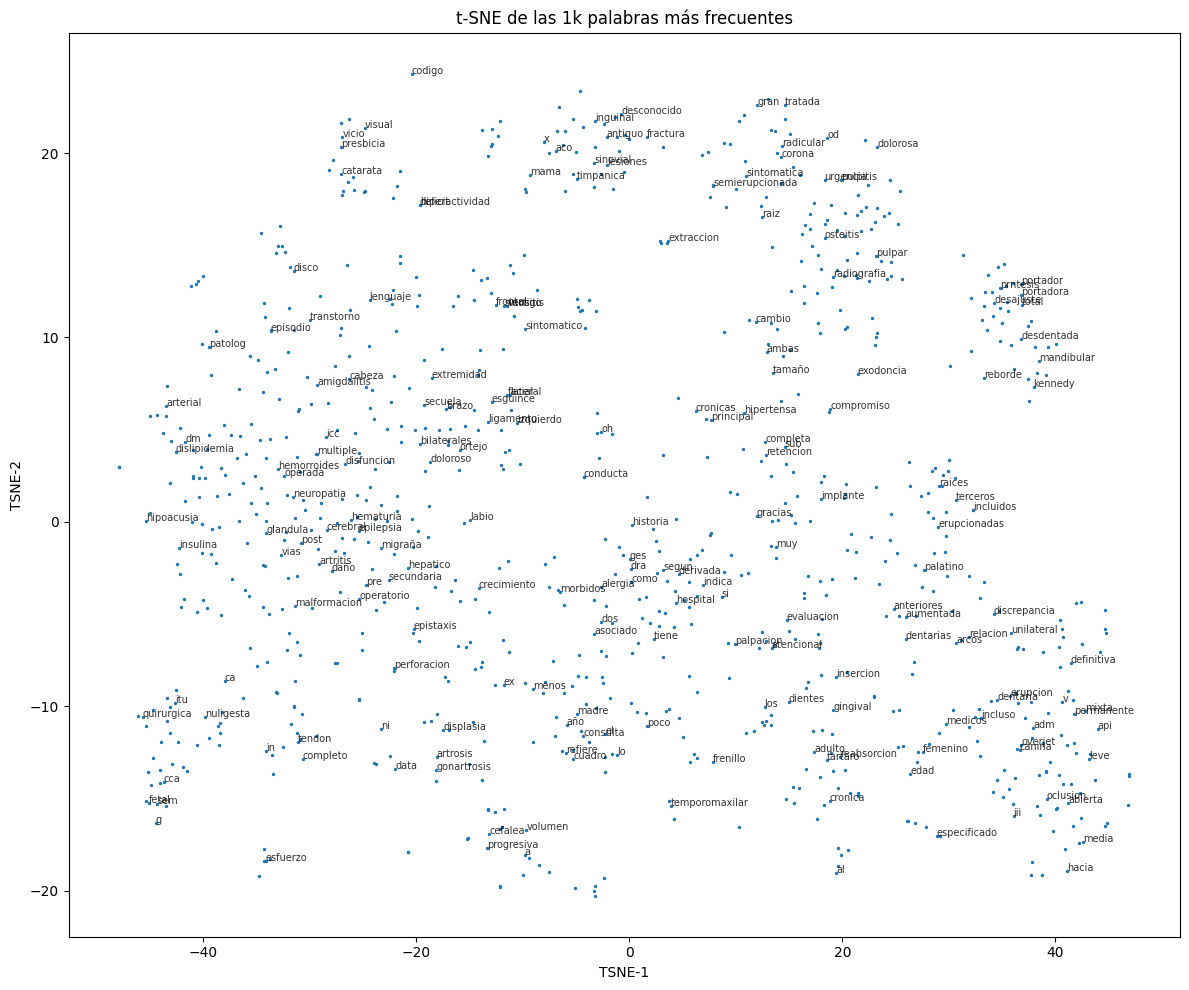

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# 1) Tomamos las 1k palabras más frecuentes
kv = model.wv  # KeyedVectors
top_n = 1000
words = kv.index_to_key[:top_n]              # ordenadas por frecuencia
X = kv.get_normed_vectors()[:top_n]          # (1k, 200) ya normalizados L2

# 2) t-SNE a 2D
tsne = TSNE(
    n_components=2,
    init="pca",            # inicia con PCA (suele converger mejor)
    perplexity=30,         # si top_n es muy grande y/o corpus diverso, puedes subir a 40-50
    learning_rate="auto",
    n_iter=1000,
    random_state=42,
    verbose=1,
    method="barnes_hut",   # eficiente para 2D
)
emb_2d = tsne.fit_transform(X)            # shape: (1k, 2)

# 4) Gráfico básico (sin colorear, para evitar ruido visual)
plt.figure(figsize=(12, 10))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=2)
plt.title("t-SNE de las 1k palabras más frecuentes")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")

# 5) Etiquetar solo una muestra (p. ej., 200) para no saturar
rng = np.random.default_rng(42)
idx_sample = rng.choice(len(words), size=min(200, len(words)), replace=False)
for i in idx_sample:
    plt.annotate(words[i], (emb_2d[i, 0], emb_2d[i, 1]), fontsize=7, alpha=0.8)

plt.tight_layout()
plt.show()

### Comparación

Existen word embeddings precalculados disponibles libremente en internet. Utilizaremos como embedding de dominio general el Spanish Billion Words Corpus Embeddings y compararemos el rendimiento sobre pruebas clínicas de los 2 embeddings.

Cargamos los embeddings.

In [18]:
!curl -L -o sbwce_slim.txt https://raw.githubusercontent.com/dccuchile/CC66Q/main/tutorials/data/sbwce_slim.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27.2M  100 27.2M    0     0  19.6M      0  0:00:01  0:00:01 --:--:-- 19.6M


In [19]:
sbwce = gensim.models.KeyedVectors.load_word2vec_format("sbwce_slim.txt")

Podemos observar que si probamos este modelo sobre palabras del dominio clínico, los resultados de estas pruebas son desfavorables.

In [20]:
sbwce.most_similar("pieza")

[('piezas', 0.6851319074630737),
 ('obra', 0.5722230672836304),
 ('cuerda', 0.5271234512329102),
 ('figura', 0.49860382080078125),
 ('máquina', 0.48856663703918457),
 ('elemento', 0.47292402386665344),
 ('clave', 0.47156471014022827),
 ('escultura', 0.46959367394447327),
 ('montaje', 0.46599438786506653),
 ('estructura', 0.4569995105266571)]

In [57]:
for w1, w2 in pairs:
    try:
        print('%r\t%r\t%.2f' % (w1, w2, sbwce.similarity(w1, w2)))
    except KeyError as e:
        print(e)

"Key 'diente' not present"
"Key 'caries' not present"
"Key 'protesis' not present"
"Key 'hueso' not present"
'pieza'	'sangre'	0.21


In [22]:
sbwce.doesnt_match(["diente","periodontitis","cirrosis","corona","lengua"])

'corona'

Probamos una analogía típica utilizada para verificar el rendimiento de los modelos de dominio general.

In [23]:
sbwce.most_similar(positive=["mujer", "rey"], negative=["hombre"], topn=3)

[('reina', 0.7493032217025757),
 ('princesa', 0.6861547231674194),
 ('reyes', 0.6391469836235046)]

In [24]:
sbwce_2d = projector.fit_transform(sbwce.vectors)[:,:2]

In [25]:
fig = px.scatter(
    x=sbwce_2d[:,0],
    y=sbwce_2d[:,1],
    text=list(sbwce.index_to_key)
)
fig.update_traces(mode="markers")

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning:

'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.



[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.051s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.342163
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.607803
[t-SNE] KL divergence after 1000 iterations: 1.409380


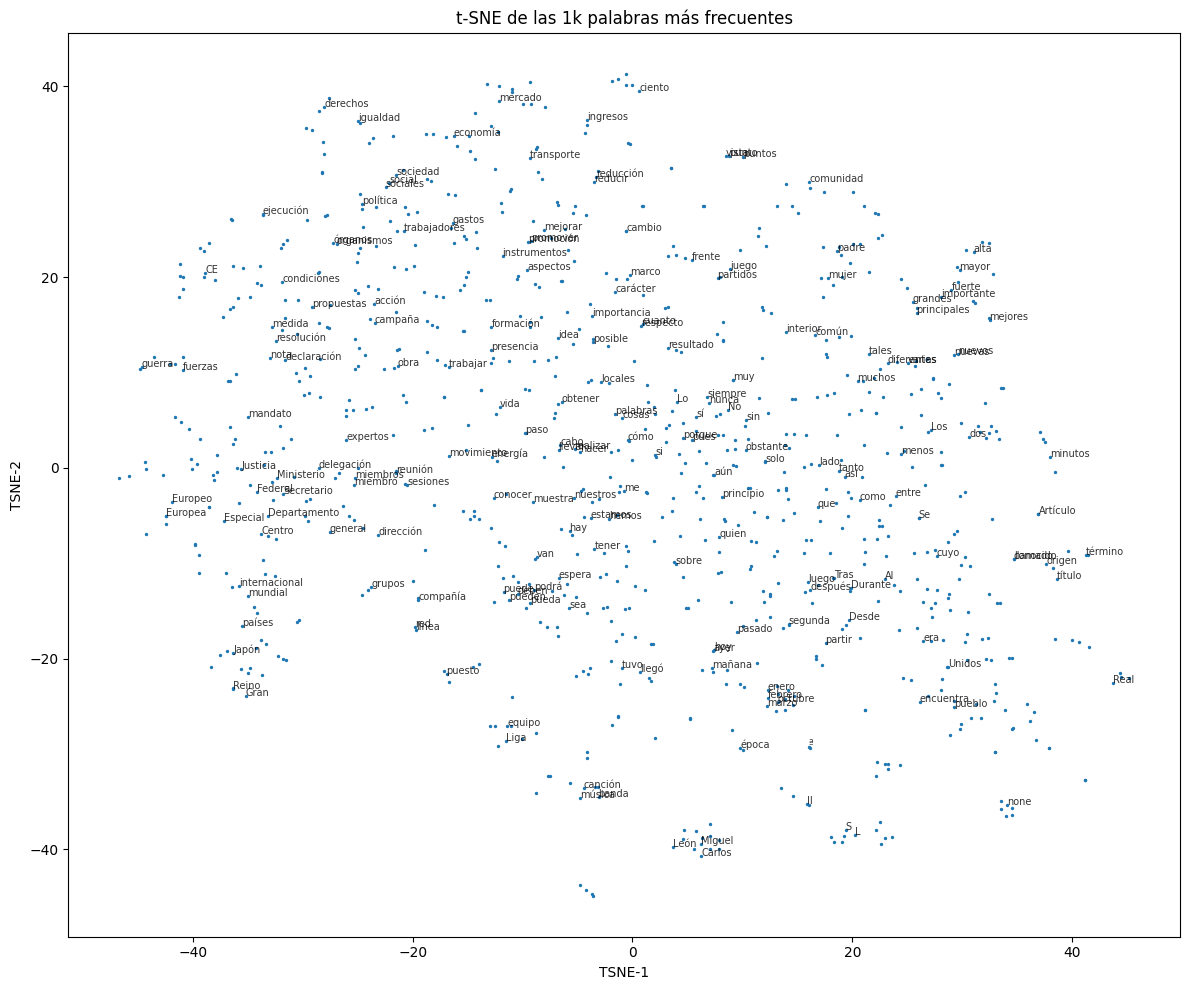

In [58]:
# 1) Tomamos las 1k palabras más frecuentes
kv = sbwce # KeyedVectors
top_n = 1000
words = kv.index_to_key[:top_n]              # ordenadas por frecuencia
X = kv.get_normed_vectors()[:top_n]          # (1k, 200) ya normalizados L2

# 2) t-SNE a 2D
tsne = TSNE(
    n_components=2,
    init="pca",            # inicia con PCA (suele converger mejor)
    perplexity=30,         # si top_n es muy grande y/o corpus diverso, puedes subir a 40-50
    learning_rate="auto",
    n_iter=1000,
    random_state=42,
    verbose=1,
    method="barnes_hut",   # eficiente para 2D
)
emb_2d = tsne.fit_transform(X)            # shape: (1k, 2)

# 4) Gráfico básico (sin colorear, para evitar ruido visual)
plt.figure(figsize=(12, 10))
plt.scatter(emb_2d[:, 0], emb_2d[:, 1], s=2)
plt.title("t-SNE de las 1k palabras más frecuentes")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")

# 5) Etiquetar solo una muestra (p. ej., 200) para no saturar
rng = np.random.default_rng(42)
idx_sample = rng.choice(len(words), size=min(200, len(words)), replace=False)
for i in idx_sample:
    plt.annotate(words[i], (emb_2d[i, 0], emb_2d[i, 1]), fontsize=7, alpha=0.8)

plt.tight_layout()
plt.show()

## Clasificación de textos

Definimos una función que nos retornará una representación de un documento desde representaciones de palabras.

In [26]:
def to_vector(tokens,model):
    """ Receives a sentence string along with a word embedding model and
    returns the vector representation of the sentence"""
    vec = np.zeros(model.vectors.shape[1]) # creates an empty vector of 300 dimensions
    for word in tokens: # iterates over the sentence
        if word in model: # checks if the word is in the word embedding
            vec += model[word] # adds every word embedding to the vector
    if np.linalg.norm(vec) > 0:
        return vec / np.linalg.norm(vec) # divides the vector by their normal
    else:
        return vec

Utilizaremos la función definida anteriormente para obtener la representación vectorial de cada uno de los ejemplos de nuestro conjunto de datos.

In [27]:
spanish_diagnostics_normalized_tokenized_vectorized = spanish_diagnostics_normalized_tokenized.map(
    lambda x: {
        "vectorized_text" : to_vector(x["tokenized_text"],model.wv)
    })

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Exploramos el espacio y verificamos que existe una separación relativamente clara entre los documentos de las distintas clases.

In [28]:
def plot_3d(x, labels):
    """Generates a 3D scatter plot."""
    fig = px.scatter_3d(
        x=x[:, 0],
        y=x[:, 1],
        z=x[:, 2],
        color=labels,
        opacity=0.5
    )
    fig.update_traces(mode="markers", marker={'size': 2})
    fig.show()

In [29]:
examples_3d = projector.fit_transform(spanish_diagnostics_normalized_tokenized_vectorized["test"]["vectorized_text"])
labels = spanish_diagnostics_normalized_tokenized_vectorized["test"].features["label"].int2str(spanish_diagnostics_normalized_tokenized_vectorized["test"]["label"])

plot_3d(examples_3d , labels)

Instanciamos y ajustamos un modelo de regresión logística para clasificar nuestros textos y vemos que este método tiene un rendimiento significativamente bueno

In [30]:
classifier = sklearn.linear_model.LogisticRegression(solver='liblinear')

In [31]:
classifier.fit(
    spanish_diagnostics_normalized_tokenized_vectorized["train"]["vectorized_text"],
    spanish_diagnostics_normalized_tokenized_vectorized["train"]["label"]
)

LogisticRegression(solver='liblinear')

In [32]:
print(sklearn.metrics.classification_report(
    spanish_diagnostics_normalized_tokenized_vectorized["test"]["label"],
    classifier.predict(spanish_diagnostics_normalized_tokenized_vectorized["test"]["vectorized_text"])
))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94     15034
           1       0.94      0.93      0.94     14966

    accuracy                           0.94     30000
   macro avg       0.94      0.94      0.94     30000
weighted avg       0.94      0.94      0.94     30000



### Comparación de Word Embeddings

Realizamos el mismo proceso de vectorización pero utilizando las representaciones de dominio general y verificamos que el rendimiento es mucho menor al anterior.

In [33]:
spanish_diagnostics_normalized_tokenized_vectorized_sbwce = spanish_diagnostics_normalized_tokenized.map(
    lambda x: {
        "vectorized_text" : to_vector(x["tokenized_text"],sbwce)
    })

Map:   0%|          | 0/70000 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

In [34]:
examples_3d_sbwce = projector.fit_transform(spanish_diagnostics_normalized_tokenized_vectorized_sbwce["test"]["vectorized_text"])
labels = spanish_diagnostics_normalized_tokenized_vectorized["test"].features["label"].int2str(spanish_diagnostics_normalized_tokenized_vectorized["test"]["label"])

plot_3d(examples_3d_sbwce , labels)

In [35]:
classifier_sbwce = sklearn.linear_model.LogisticRegression(solver='liblinear')

In [36]:
classifier.fit(
    spanish_diagnostics_normalized_tokenized_vectorized_sbwce["train"]["vectorized_text"],
    spanish_diagnostics_normalized_tokenized_vectorized_sbwce["train"]["label"]
)

LogisticRegression(solver='liblinear')

In [37]:
print(sklearn.metrics.classification_report(
    spanish_diagnostics_normalized_tokenized_vectorized_sbwce["test"]["label"],
    classifier.predict(spanish_diagnostics_normalized_tokenized_vectorized_sbwce["test"]["vectorized_text"])
))

              precision    recall  f1-score   support

           0       0.76      0.90      0.82     15034
           1       0.87      0.72      0.79     14966

    accuracy                           0.81     30000
   macro avg       0.82      0.81      0.81     30000
weighted avg       0.82      0.81      0.81     30000

